This notebook is to illustrate the performance differences by using basic spacy preprocess(default vs customized pretrained) tokenizer and by using nltk tokenizer. There are also some parameter tuning at the end.

Using Ski-kit learn Complement Naive bayer model to performance recommand system

In [2]:
!pip install -U scikit-learn
!pip install --upgrade gensim
!pip install -U spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-2.3.0/en_core_web_lg-2.3.0.tar.gz



     |████████████████████████████████| 6.8MB 2.5MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 24.2MB 168kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 10.0MB 2.8MB/s 
     |████████████████████████████████| 2.1MB 32.1MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 782.7MB 21kB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.3.0-cp36-none-any.whl size=782931390 sha256=62310897ac7f7c21d0d83eb5fa79e808931e1c4456dabe2fde4840016b544d10
  Stored in directory: /root/.cache/pip/w

Dependancies

In [7]:
import os, re
import gensim
import sklearn
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split,KFold,cross_val_score,cross_val_predict,GridSearchCV,StratifiedKFold,cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer, multilabel_confusion_matrix, plot_confusion_matrix,classification_report,f1_score
from sklearn.utils.class_weight import compute_sample_weight

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import spacy
import en_core_web_lg




In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Load large core corpus trained by web based on lanauage by spacy

In [5]:
nlp = en_core_web_lg.load()

upload data-prcoessed.csv from local


In [8]:
from google.colab import files
uploaded = files.upload()

Saving data-processed.csv to data-processed.csv


customize function processing NER. This step is not perfect I will show it in a different notebook later on

In [42]:
def clean_personinfo(df):
    """

    :param df:
    :type df:
    :return:
    :rtype:
    """
    replace_word = "someone"
    return [re.sub(r"\{\{[^\{\}]+\}\}\w?", replace_word, str1) for str1 in df]

NLTK version of preprocessing to remove stop words and non-letter tokens. Lemmatization is also performed

In [10]:
def spacy_tokenizer(df_sent):
    """

    :param df:
    :type df:
    :return:
    :rtype:
    """
    spy_txt = nlp(df_sent)
    return [w.lemma_ if w.lemma_ != "-PRON-" else w.text
            for w in spy_txt
            if w.is_stop == False
            and not w.is_punct
            ]


In [11]:
def nltk_tokenizer(df_sent):
    lemmatizer = nltk.WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    tokens = word_tokenize(df_sent)
    words = [word.lower() for word in tokens if word.isalpha()]  # get rid of puntuation
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]

    return words


function for showing difference between two tokenizer

In [12]:
def different_tokens(str1,str2):
  return {"first token list":[x for x in str1 if x not in str2],"second token list": [y for y in str2  if y not in str1 ]}

In [13]:
yw_df = pd.read_csv("data-processed.csv")
yw_clean = yw_df["DESCRIPTION"]

test =[w for w in nlp(yw_clean[0])]
print(spacy_tokenizer(yw_clean[0]))
print(test)
print(nltk_tokenizer(yw_clean[0]))
print(different_tokens(spacy_tokenizer(yw_clean[0]),nltk_tokenizer(yw_clean[0])))



['staff', 'hear', 'loud', 'yell', 'noise', 'unit', 'staff', 'check', 'breathe', 'irregularly', 'appear', 'unable', 'catch', 'breath', 'tell', 'staff', 'breathe', 'want', 'ambulance', 'staff', 'ems', 'em', 'fire', 'arrive', 'assess', 'state', 'vital', 'good', 'appear', 'struggle', 'anxiety', 'decline', 'hospital', 'em']
[staff, could, hear, *, *, make, loud, yelling, noise, from, unit, staff, check, on, *, *, who, be, breathe, irregularly, and, appear, unable, to, catch, her, breath, *, *, tell, staff, she, could, not, breathe, and, want, an, ambulance, staff, call, ems, em, and, fire, arrive, and, assess, *, *, and, state, that, her, vitals, be, good, and, she, appear, to, be, struggle, with, anxiety, *, *, decline, go, to, hospital, with, em]
['staff', 'could', 'hear', 'make', 'loud', 'yelling', 'noise', 'unit', 'staff', 'check', 'breathe', 'irregularly', 'appear', 'unable', 'catch', 'breath', 'tell', 'staff', 'could', 'breathe', 'want', 'ambulance', 'staff', 'call', 'em', 'em', 'fire

This note book focus on Multi-label classfication, so LabelEncoder is provided.

In [14]:
encoder = LabelEncoder()
yw_txt_cats = encoder.fit_transform([t for t in yw_df['INCIDENT_TYPE_1']])

weight distribution function based on frequency of classes

In [15]:
def count_weight(categories,total_files = yw_txt_cats):
  weight_dict = {lb:0 for lb in list(set(yw_txt_cats))}
  for cat in categories:
      weight_dict[cat] += 1 
   
  return weight_dict

Build model with TfidfVector 

In [16]:
word_vec = TfidfVectorizer(tokenizer=spacy_tokenizer,
                                          token_pattern=r'\b\w+\b',
                                          ngram_range=(1, 2),
                                          min_df=2)
yw_clean = word_vec.fit_transform(yw_clean)

split the data into train and test

In [17]:
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(
                                        yw_clean, 
                                        yw_txt_cats,
                                        train_size=0.75,
                                        random_state = 32,
                                        shuffle = True)

weights_dict = count_weight(yw_txt_cats)
weight_load = compute_sample_weight(weights_dict,yw_txt_cats)
weight_train,weight_test = train_test_split(
                                        weight_load,
                                        train_size=0.75,
                                        random_state = 32,
                                        shuffle = True)

train and score: accuracy score


In [18]:
cnb = ComplementNB()
cnb.fit(X_train_set,y_train_set)
score_train_cnb = cnb.score(X_test_set, y_test_set,sample_weight=weight_test)
y_pred = cnb.predict(X_test_set)
y_true = y_test_set
bal_score_train_cnb = balanced_accuracy_score(y_true=y_true,y_pred=y_pred, sample_weight=weight_test)





svm = SVC()
svm.fit(X_train_set,y_train_set,sample_weight = weight_train)
score_train_svm = svm.score(X_test_set, y_test_set,weight_test)
y_pred = svm.predict(X_test_set)
y_true = y_test_set
bal_score_train_svm = balanced_accuracy_score(y_true=y_true,y_pred=y_pred, sample_weight=weight_test)

print("Complement NB Accuracy score on test set is {0:.2f}".format(score_train_cnb))
print("Complement NB Balanced Accuracy score on test set is {0:.2f}".format(bal_score_train_cnb))
print("SVM NB Accuracy score on test set is {0:.2f}".format(score_train_svm))
print("SVM-C Accuracy score on test set is {0:.2f}".format(bal_score_train_svm))


Complement NB Accuracy score on test set is 0.93
Complement NB Balanced Accuracy score on test set is 0.38
SVM NB Accuracy score on test set is 0.93
SVM-C Accuracy score on test set is 0.23


Cross-Validation: We show what is the scores on train set with 5-fold.


In [44]:

cv_cnb = cross_validate(cnb,
                     X = X_train_set,
                     y = y_train_set,
                     scoring = ["balanced_accuracy","accuracy"],
                     fit_params={'sample_weight': weight_train}
                      )

print("String keys for cross-validation {}".format(cv_cnb.keys()))
print("Complement NB accuracy scores on 5-fold cross-validation: {}".format(cv_cnb["test_accuracy"]))
print("Complement NB balanced accuracy scores on 5-fold cross-validation: {}".format(cv_cnb["test_balanced_accuracy"]))

cv_svm = cross_validate(svm,
                     X = X_train_set,
                     y = y_train_set,
                     scoring = ["balanced_accuracy","accuracy"],
                     fit_params={'sample_weight': weight_train},
                  
                      )

print("SVM Accuracy scores on 5-fold cross-validation: {}".format(cv_svm["test_accuracy"]))
print("SVM Balanced accuracy scores on 5-fold cross-validation: {}".format(cv_svm["test_balanced_accuracy"]))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


String keys for cross-validation dict_keys(['fit_time', 'score_time', 'test_balanced_accuracy', 'test_accuracy'])
Complement NB accuracy scores on 5-fold cross-validation: [0.41176471 0.44       0.48       0.58       0.46      ]
Complement NB balanced accuracy scores on 5-fold cross-validation: [0.28492719 0.26393939 0.27371114 0.48642267 0.1635183 ]
SVM Accuracy scores on 5-fold cross-validation: [0.45098039 0.5        0.46       0.5        0.48      ]
SVM Balanced accuracy scores on 5-fold cross-validation: [0.18181818 0.21666667 0.11275089 0.20779221 0.11904762]


In [20]:
predicted_test = cnb.predict(X_test_set)
test_score = accuracy_score(y_test_set,predicted_test,sample_weight=weight_test)
predicted_train = cnb.predict(X_train_set)
train_score = accuracy_score(y_train_set,predicted_train,sample_weight=weight_train)

predicted_btest = cnb.predict(X_test_set)
test_balance = balanced_accuracy_score(y_test_set,predicted_btest,sample_weight=weight_test)
predicted_btrain = cnb.predict(X_train_set)
train_balance = balanced_accuracy_score(y_train_set,predicted_btrain,sample_weight=weight_train)

print("complment NB test accuracy score is :{:.2%} \n".format(test_score))
print("complment NB train accuracy score is :{:.2%} \n".format(train_score))
print("complment NB test balance accuracy score is :{:.2%} \n".format(test_balance))
print("complment NB train balance accuracy score is :{:.2%} \n".format(train_balance))

complment NB test accuracy score is :93.48% 

complment NB train accuracy score is :97.48% 

complment NB test balance accuracy score is :37.69% 

complment NB train balance accuracy score is :85.88% 



In [21]:
predicted_test = svm.predict(X_test_set)
test_score = accuracy_score(y_test_set,predicted_test,sample_weight=weight_test)
predicted_train = svm.predict(X_train_set)
train_score = accuracy_score(y_train_set,predicted_train,sample_weight=weight_train)

predicted_btest = svm.predict(X_test_set)
test_balance = balanced_accuracy_score(y_test_set,predicted_btest,sample_weight=weight_test)
predicted_btrain = svm.predict(X_train_set)
train_balance = balanced_accuracy_score(y_train_set,predicted_btrain,sample_weight=weight_train)

print("SVM-C test accuracy score is :{:.2%} \n".format(test_score))
print("SVM-C train accuracy score is :{:.2%} \n".format(train_score))
print("SVM-C test balance accuracy score is :{:.2%} \n".format(test_balance))
print("SVMC-C train balance accuracy score is :{:.2%} \n".format(train_balance))

SVM-C test accuracy score is :92.58% 

SVM-C train accuracy score is :99.81% 

SVM-C test balance accuracy score is :23.23% 

SVMC-C train balance accuracy score is :92.04% 



Text(0.5, 1.0, 'Complement NB confusion matrix on train set with normalization')

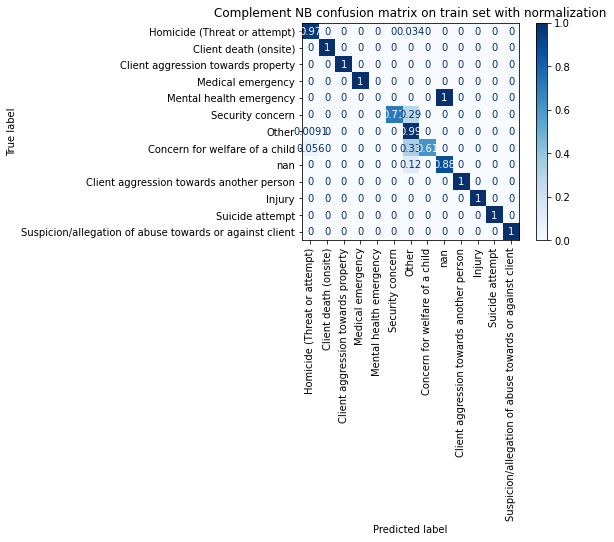

In [45]:
true_train = [encoder.inverse_transform([cat])[0] for cat in y_train_set]
train_class = list(set(true_train))
disp = plot_confusion_matrix(cnb, 
                             X_train_set,
                             y_train_set,
                             sample_weight=weight_train,
                             normalize='true',
                             display_labels= train_class,
                             cmap=plt.cm.Blues,
                             xticks_rotation='vertical'
                            )
title = "Complement NB confusion matrix on train set with normalization"
disp.ax_.set_title(title)

Text(0.5, 1.0, 'Complement NB confusition matrix on test set with normalization')

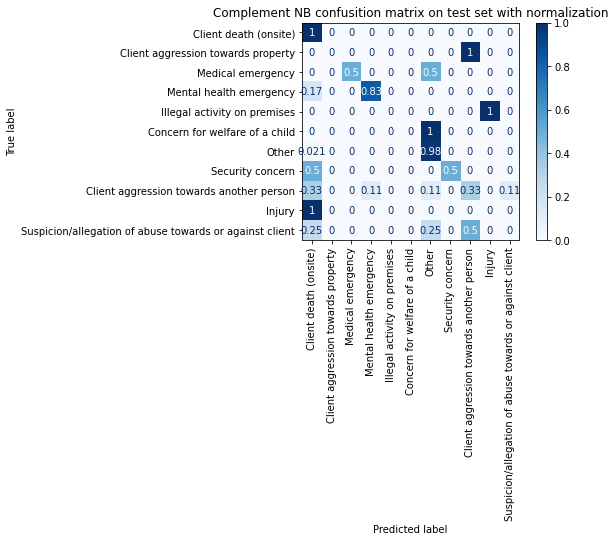

In [23]:
true_test = [encoder.inverse_transform([cat])[0] for cat in y_test_set]
test_class = list(set(true_test))
disp = plot_confusion_matrix(cnb, 
                             X_test_set,
                             y_test_set,
                             sample_weight=weight_test,
                             normalize='true',
                             display_labels= test_class,
                             cmap=plt.cm.Blues,
                             xticks_rotation='vertical'
                            )
title = "Complement NB confusition matrix on test set with normalization"
disp.ax_.set_title(title)

Text(0.5, 1.0, 'SVM-C confusition matrix on train set with normalization')

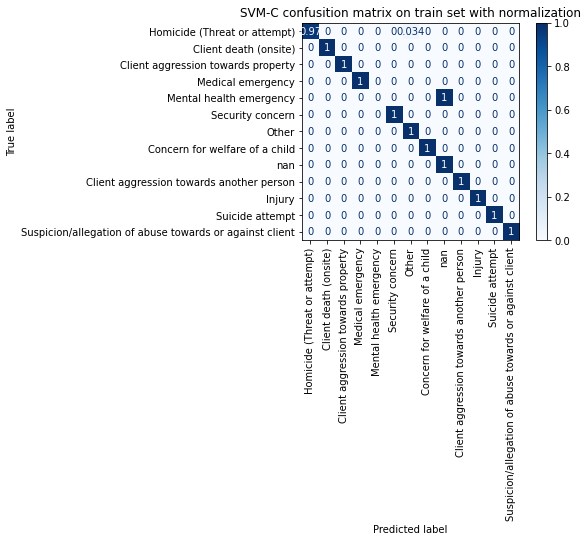

In [24]:
true_train = [encoder.inverse_transform([cat])[0] for cat in y_train_set]
train_class = list(set(true_train))
disp = plot_confusion_matrix(svm, 
                             X_train_set,
                             y_train_set,
                             sample_weight=weight_train,
                             normalize='true',
                             display_labels= train_class,
                             cmap=plt.cm.Blues,
                             xticks_rotation='vertical'
                            )
title = "SVM-C confusition matrix on train set with normalization"
disp.ax_.set_title(title)

Text(0.5, 1.0, 'SVM-C confusition matrix on test set with normalization')

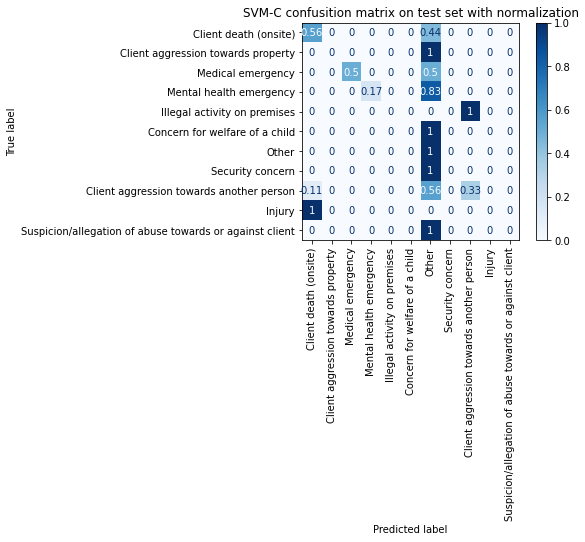

In [25]:
true_test = [encoder.inverse_transform([cat])[0] for cat in y_test_set]
test_class = list(set(true_test))
disp = plot_confusion_matrix(svm, 
                             X_test_set,
                             y_test_set,
                             sample_weight=weight_test,
                             normalize='true',
                             display_labels= test_class,
                             cmap=plt.cm.Blues,
                             xticks_rotation='vertical'
                            )
title = "SVM-C confusition matrix on test set with normalization"
disp.ax_.set_title(title)

In [26]:
predicted_train = [encoder.inverse_transform([cat])[0] for cat  in cnb.predict(X_train_set)]
print("Complment NB train set classfication report\n")
print(classification_report(true_train,predicted_train, sample_weight = weight_train,labels=encoder.classes_ ,target_names = encoder.classes_))

Complment NB train set classfication report

                                                         precision    recall  f1-score   support

               Client aggression towards another person       0.86      0.97      0.91    1102.0
                     Client aggression towards property       1.00      1.00      1.00       6.0
                                  Client death (onsite)       1.00      1.00      1.00       3.0
                         Concern for welfare of a child       1.00      1.00      1.00     135.0
                           Homicide (Threat or attempt)       0.00      0.00      0.00       1.0
                           Illegal activity on premises       0.00      0.00      0.00       0.0
                                                 Injury       1.00      0.71      0.83      63.0
                                      Medical emergency       0.98      0.99      0.99   17270.0
                                Mental health emergency       1.00      0.61     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
predicted_test = [encoder.inverse_transform([cat])[0] for cat  in cnb.predict(X_test_set)]

print("ComplmentNB test set classfication report\n")
print(classification_report(true_test,predicted_test,sample_weight = weight_test,labels=encoder.classes_ ,target_names = encoder.classes_))

ComplmentNB test set classfication report

                                                         precision    recall  f1-score   support

               Client aggression towards another person       0.49      1.00      0.66     342.0
                     Client aggression towards property       0.00      0.00      0.00       3.0
                                  Client death (onsite)       1.00      0.50      0.67       6.0
                         Concern for welfare of a child       0.64      0.83      0.72      90.0
                           Homicide (Threat or attempt)       0.00      0.00      0.00       0.0
                           Illegal activity on premises       0.00      0.00      0.00       1.0
                                                 Injury       0.00      0.00      0.00      18.0
                                      Medical emergency       0.99      0.98      0.98    7379.0
                                Mental health emergency       1.00      0.50      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
predicted_train = [encoder.inverse_transform([cat])[0] for cat  in svm.predict(X_train_set)]
true_train = [encoder.inverse_transform([cat])[0] for cat in y_train_set]
print("SVM-C model train set classfication report\n")
print(classification_report(true_train,predicted_train, sample_weight = weight_train,labels=encoder.classes_ ,target_names = encoder.classes_))

SVM-C model train set classfication report

                                                         precision    recall  f1-score   support

               Client aggression towards another person       1.00      0.97      0.98    1102.0
                     Client aggression towards property       1.00      1.00      1.00       6.0
                                  Client death (onsite)       1.00      1.00      1.00       3.0
                         Concern for welfare of a child       1.00      1.00      1.00     135.0
                           Homicide (Threat or attempt)       0.00      0.00      0.00       1.0
                           Illegal activity on premises       0.00      0.00      0.00       0.0
                                                 Injury       1.00      1.00      1.00      63.0
                                      Medical emergency       1.00      1.00      1.00   17270.0
                                Mental health emergency       1.00      1.00      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
predicted_test = [encoder.inverse_transform([cat])[0] for cat  in svm.predict(X_test_set)]

print("SVM-C test set classfication report\n")
print(classification_report(true_test,predicted_test,sample_weight = weight_test,labels=encoder.classes_ ,target_names = encoder.classes_))

SVM-C test set classfication report

                                                         precision    recall  f1-score   support

               Client aggression towards another person       0.76      0.56      0.64     342.0
                     Client aggression towards property       0.00      0.00      0.00       3.0
                                  Client death (onsite)       1.00      0.50      0.67       6.0
                         Concern for welfare of a child       1.00      0.17      0.29      90.0
                           Homicide (Threat or attempt)       0.00      0.00      0.00       0.0
                           Illegal activity on premises       0.00      0.00      0.00       1.0
                                                 Injury       0.00      0.00      0.00      18.0
                                      Medical emergency       0.93      1.00      0.96    7379.0
                                Mental health emergency       0.00      0.00      0.00   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Detailed parameter fine tuning based on balanaced accuracy and accuracy score on SVC 

In [30]:
svc_params_list = {"C":np.logspace(-5,0,6),
                   'kernel':['linear','poly','sigmoid'],
                   'gamma' :['scale','auto'],
                   'decision_function_shape':['ovo','ovr'],
                   "class_weight":['balanced',None]}
svc_params_list

{'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
 'class_weight': ['balanced', None],
 'decision_function_shape': ['ovo', 'ovr'],
 'gamma': ['scale', 'auto'],
 'kernel': ['linear', 'poly', 'sigmoid']}

In [31]:
cv_ = GridSearchCV(svm,
                   param_grid=svc_params_list,   
                   refit = False              
                  )
cv_.fit(X_train_set,y_train_set)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                         'class_weight': ['balanced', None],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'sigmoid']},
             refit=False)

In [50]:
cv_.best_params_

{'C': 1.0,
 'class_weight': 'balanced',
 'decision_function_shape': 'ovo',
 'gamma': 'scale',
 'kernel': 'linear'}

In [33]:
cv_.best_score_

0.5816470588235294

In [87]:
svm_op = SVC(C= 1.0,class_weight= 'balanced',decision_function_shape =  'ovo',gamma = 'scale',kernel = 'linear')
svm_op.fit(X_train_set,y_train_set,sample_weight=weight_train)
cv_s = cross_validate(
    svm_op,# change to svm vairable to see different before and after the fine tuning
    X_train_set,
    y_train_set,
    scoring=['recall_weighted','precision_weighted','balanced_accuracy','accuracy'],
    fit_params={'sample_weight':weight_train},
    verbose = 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.

[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


In [64]:
cv_s['test_balanced_accuracy']

array([0.3008658 , 0.33212121, 0.3227076 , 0.39413617, 0.13695396])

In [65]:
cv_s['test_accuracy']

array([0.52941176, 0.54      , 0.58      , 0.64      , 0.46      ])

In [66]:
cv_s['test_precision_weighted']

array([0.37881264, 0.47005042, 0.51088889, 0.58007246, 0.3416092 ])

In [67]:
cv_s['test_recall_weighted']

array([0.52941176, 0.54      , 0.58      , 0.64      , 0.46      ])

In [68]:
cv_nb = GridSearchCV(cnb,
                   param_grid={'alpha':[0.1,0.5,1]},   
                   refit = False,
                  )
cv_nb.fit(X_train_set,y_train_set)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(estimator=ComplementNB(), param_grid={'alpha': [0.1, 0.5, 1]},
             refit=False)

In [69]:
cv_nb.best_score_

0.5859607843137256

In [70]:
cv_nb.best_params_

{'alpha': 0.5}

In [88]:
cnb_op = ComplementNB(alpha=0.5)
cnb_op.fit(X_train_set,y_train_set,sample_weight=weight_train)
cv_b= cross_validate(
    cnb_op,# change to svm vairable to see different before and after the fine tuning
    X_train_set,
    y_train_set,
    scoring=['recall_weighted','precision_weighted','balanced_accuracy','accuracy'],
    fit_params={'sample_weight':weight_train},
    verbose = 2)

[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.

************Important finding after fine tuning******************

*   From performance perspect, SVM-C model outperform Complment Naive Bayer model by marginally
*   From train time and score time, Complment Naive Bayer model offer much strong edge




In [93]:
print("balanced accuracy: complmentNB is {} SVM-C is {}".format([ '%.2f'% elem for elem in cv_b['test_balanced_accuracy']],['%.2f'% elem for elem in cv_s['test_balanced_accuracy']]))
print("accuracy: complmentNB is {} SVM-C is {}".format(['%.2f'% elem for elem in cv_b['test_accuracy']],['%.2f'% elem for elem in cv_s['test_accuracy']]))
print("test_precision_weighted: complmentNB is {} SVM-C is {}".format(['%.2f'% elem for elem in cv_b['test_precision_weighted']],['%.2f'% elem for elem in cv_s['test_precision_weighted']]))
print("test_recall_weighted: complmentNB is {} SVM-C is {}".format(['%.2f'% elem for elem in cv_b['test_recall_weighted']],['%.2f'% elem for elem in cv_s['test_recall_weighted']]))


print("time to fit(train): complmentNB is {:.4f} SVM-C is {:.4f}".format(np.average(cv_b['fit_time']),np.average(cv_s['fit_time'])))
print("time to score: complmentNB is {:.4f} SVM-C is {:.4f}".format(np.average(cv_b['score_time']),np.average(cv_s['score_time'])))



balanced accuracy: complmentNB is ['0.29', '0.24', '0.26', '0.49', '0.16'] SVM-C is ['0.30', '0.33', '0.32', '0.39', '0.14']
accuracy: complmentNB is ['0.45', '0.42', '0.48', '0.58', '0.46'] SVM-C is ['0.53', '0.54', '0.58', '0.64', '0.46']
test_precision_weighted: complmentNB is ['0.37', '0.50', '0.51', '0.60', '0.45'] SVM-C is ['0.38', '0.47', '0.51', '0.58', '0.34']
test_recall_weighted: complmentNB is ['0.45', '0.42', '0.48', '0.58', '0.46'] SVM-C is ['0.53', '0.54', '0.58', '0.64', '0.46']
time to fit(train): complmentNB is 0.0050 SVM-C is 0.0554
time to score: complmentNB is 0.0037 SVM-C is 0.0076


Text(0.5, 1.0, 'SVM-C confusition matrix on all dataset with normalization')

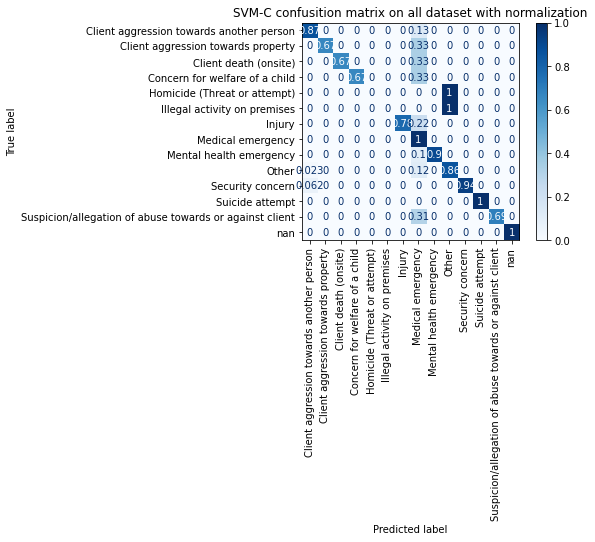

In [43]:
true_total = yw_df['INCIDENT_TYPE_1']
disp = plot_confusion_matrix(svm, 
                             yw_clean, 
                             yw_txt_cats,
                             sample_weight=weight_load,
                             normalize='true',
                             display_labels= encoder.classes_,
                             cmap=plt.cm.Blues,
                             xticks_rotation='vertical'
                            )
title = "SVM-C confusition matrix on all dataset with normalization"
disp.ax_.set_title(title)